# Disparity Analysis and Logistic Regression

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import random
import math
import json

import istarmap  # import to apply monkey patch to multiprocess
import multiprocess
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy import stats 
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.preprocessing import StandardScaler, RobustScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

from aggregators import bucket_and_bin, filter_df
from config import city2ap

In [3]:
# ouputs
fn_distance = '../data/output/figs/fig2_dist.csv'
fn_disparity = '../data/output/tables/table1_disparities_by_city.csv'
fn_regression_all = '../data/output/tables/table2_regression_outputs_all.csv'
fn_regression_income = '../data/output/tables/table3a_regression_outputs_income.csv'
fn_regression_race = '../data/output/tables/table3b_regression_outputs_race.csv'
fn_regression_redlining = '../data/output/tables/table3c_regression_outputs_redlining.csv'


fn_observed_income = '../data/output/figs/fig4_income.csv'
fn_adjusted_income = '../data/output/figs/fig5_income.csv'
fn_observed_race = '../data/output/figs/fig4_race.csv'
fn_adjusted_race= '../data/output/figs/fig5_race.csv'
fn_observed_redlining = '../data/output/figs/fig4_redlining.csv'
fn_adjusted_redlining = '../data/output/figs/fig5_redlining.csv'

# inputs
fn_att = '../data/output/speed_price_att.csv.gz'
fn_centurylink = '../data/output/speed_price_centurylink.csv.gz'
fn_verizon = '../data/output/speed_price_verizon.csv.gz'
fn_earthlink = '../data/output/speed_price_earthlink.csv.gz'
inputs = {
    "AT&T" : fn_att,
    "CenturyLink": fn_centurylink,
    "Verizon": fn_verizon,
    "EarthLink" : fn_earthlink
}

# params
recalculate = True
n_jobs = 10

In [4]:
# how many cities and offers do we have?
c = 0
cities = set()
for (isp, fn) in inputs.items():
    d = filter_df(fn, isp=isp)
    cities.update(d.major_city.unique())
    c += len(d)
    print(f"{isp} we analyzed {len(d)} addresses from {d.major_city.nunique()} cities")
c, len(cities)

AT&T we analyzed 349703 addresses from 20 cities
CenturyLink we analyzed 180067 addresses from 15 cities


/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nyc)


Verizon we analyzed 223259 addresses from 8 cities
EarthLink we analyzed 398401 addresses from 33 cities


(1151430, 43)

In [42]:
def which_has_largest_proportion(df, col='income_level', bins=['Low'], comparison=[], limit=300):
    sample1 = df[df[col].isin(bins)]
    if len(comparison) != 0:
        sample2 = df[df[col].isin(comparison)]
    else:
        sample2 = df[~df[col].isin(bins)]
        
    if len(sample1) < limit or len(sample2) < limit:
        return None, None, None, 'small bin'
    
    try:
        prop1 = round(len(sample1[sample1.is_slow == 1]) / len(sample1), 4)
        prop2 = round(len(sample2[sample2.is_slow == 1]) / len(sample2), 4)
        return prop1, prop2, round(prop1 - prop2, 3) >= .05, None
    except Exception as e:
        print(e, df.head(2))
        return None, None, None, e

def has_disparity(df, isp, params, limitations=False):
    """
    Checks for disparities in each city.
    """
    iv = params['iv']
    data = []
    
    s = df.groupby('major_city').race_perc_non_white.quantile([.25,.75]).unstack()
    s['delta'] = s[0.75] - s[0.25]
    race_cities = set(s[s.delta >= .2].index)
    
    for (city, state), _df in df.groupby(['major_city', 'state']):
        uniform = False
        _df = bucket_and_bin(_df, limitations=limitations)
        
        n_slow = len(_df[_df.is_slow == True])
        n_not_slow = len(_df[_df.is_slow == False])
        n_all = len(_df)
        
        variety = _df.speed_down_bins.value_counts(normalize=True)
        variety[variety >= .95]
        
        if len(variety[variety >= .95]) != 0:
            uniform = True
            
        if iv == 'income':
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                                 comparison=params['comparison'])

        elif iv == 'redlining':
            _df_rated = _df[~_df.redlining_grade.isnull()]
            if len(_df_rated) / n_all <= .05:
                data.append({'major_city': city, 'state': state, 'isp': isp,
                             f'prop_slow_{iv}_exposure': None,
                             f'prop_slow_{iv}_treatment': None,
                             f'prop_slow_{iv}_delta' : None,
                             f'uniform_speed_{iv}': uniform,
                             f'flag_{iv}': 'not HOLC graded'})
                continue
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                           comparison=params['comparison'])
        elif iv == 'race':
            n_minority_white = len(_df[_df.race_perc_non_white > .50])
            n_majority_white = len(_df[_df.race_perc_non_white < .50])
            # check only cities with at least 5 percent of addresses in minority white.
            if (n_minority_white / n_all <= .05) or (n_majority_white / n_all <=.05):
                data.append({'major_city': city, 'state': state, 'isp': isp,
                         f'prop_slow_{iv}_exposure': None,
                         f'prop_slow_{iv}_treatment': None,
                         f'prop_slow_{iv}_delta' : None,
                         f'uniform_speed_{iv}': uniform,
                         f'flag_{iv}' : 'no diversity'})
                continue
            a, b, is_larger, flag = which_has_largest_proportion(_df, col=params['col'], bins=params['grades'],
                                                          comparison=params['comparison'])

        data.append({
            'major_city': city,
            'state': state,
            f'slowest_{iv}' : is_larger,
            'isp': isp,
            f'prop_slow_{iv}_exposure': a,
            f'prop_slow_{iv}_treatment': b,
            f'prop_slow_{iv}_delta' : a-b if a else None,
            f'uniform_speed_{iv}': uniform,
            f'flag_{iv}': flag
        })
        
    return data

In [5]:
# renaming columns, because I am not as smart as I think I am...
col2colrename = {
    'prop_slow_income_exposure': 'pct_slow_lower_income',
    'prop_slow_income_treatment': 'pct_slow_upper_income',
    'prop_slow_income_delta' : 'income_pct_pt_diff',
    'prop_slow_race_exposure': 'pct_slow_least_white',
    'prop_slow_race_treatment': 'pct_slow_most_white',
    'prop_slow_race_delta' : 'race_pct_pt_diff',
    'prop_slow_redlining_exposure': 'pct_slow_d_rated',
    'prop_slow_redlining_treatment': 'pct_slow_ab_rated',
    'prop_slow_redlining_delta' : 'redlining_pct_pt_diff',
    'uniform_speed_income': 'uniform_speed',
    'slowest_income': 'income_disparity',
    'slowest_race': 'race_disparity',
    'slowest_redlining': 'redlining_disparity'
}

back2colname = {v:k for k,v in col2colrename.items()}

In [6]:
income_params = {'iv': "income", 'grades': ['Low'], 'col': 'income_level'}
race_params = {'iv': "race", 'grades': ['least white'], 'col': 'race_quantile'}
redlining_params = {'iv': "redlining", 'grades': ['D'], 'col': 'redlining_grade'}

# Treatment group
income_params['comparison'] = ['Upper Income']
race_params['comparison'] = ['most white']
redlining_params['comparison'] = ['A', 'B']

In [43]:
limitations = False # set to True for different categorization criteria for income and race/ethnicity

if not os.path.exists(fn_disparity) or recalculate:
    table = pd.DataFrame()
    for isp, fn in tqdm(inputs.items()):
        df = filter_df(fn, isp)
        income_data = has_disparity(df, isp=isp, params=income_params, limitations=limitations)
        race_data = has_disparity(df, isp=isp, params=race_params, limitations=limitations)
        redlining_data = has_disparity(df, isp=isp, params=redlining_params, limitations=limitations)

        df_table = pd.DataFrame(income_data).merge(
            pd.DataFrame(race_data), on=['major_city', 'isp', 'state'], how='outer'
        ).merge(
            pd.DataFrame(redlining_data), on=['major_city', 'isp', 'state'], how='outer'
        )

        table = table.append(df_table)
    table.major_city = table.major_city.str.title()
    table.columns = [col2colrename.get(c, c) for c in table.columns]
    table = table[[c for c in table.columns if c not in ['uniform_speed_race', 'uniform_speed_redlining']]]
    if not limitations:
        table.to_csv(fn_disparity, index=False)

else:
    table = pd.read_csv(fn_disparity)

  0%|          | 0/4 [00:00<?, ?it/s]<ipython-input-43-24bbfa7088d9>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(df_table)
 25%|██▌       | 1/4 [00:11<00:34, 11.44s/it]<ipython-input-43-24bbfa7088d9>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(df_table)
 50%|█████     | 2/4 [00:17<00:16,  8.35s/it]/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nyc)
<ipython-input-43-24bbfa7088d9>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  table = table.append(df_table)
 75%|███████▌  | 3/4 [00:28<00:09,  9.39s/i

In [45]:
table.to_csv(fn_disparity, index=False)


In [46]:
# all cities in the study
n_cities = table.major_city.nunique()
n_cities
trend = set(table[(table.income_disparity == True) | 
           (table.race_disparity == True) | 
           (table.redlining_disparity == True)].major_city.unique())

In [47]:
# how many cities exhibit none of these trends?
set(table[table.uniform_speed == False].major_city.unique()) - trend

{'Boise', 'Fargo'}

In [48]:
# How many cities have a redlining disparity that is 2x or greater?
table['x_red'] = table.pct_slow_d_rated.div(table.pct_slow_ab_rated)
redlined_2x_often = table[(table.x_red >= 2) & (table.uniform_speed == False)]

redlined_2x_often.major_city.unique(), redlined_2x_often.major_city.nunique()

(array(['Atlanta', 'Charlotte', 'Columbus', 'Detroit', 'Houston',
        'Indianapolis', 'Kansas City', 'Louisville', 'Milwaukee',
        'Wichita', 'Denver', 'Minneapolis', 'Phoenix', 'Portland',
        'Newark'], dtype=object),
 15)

In [49]:
for params in [income_params, race_params ,redlining_params]:
    iv = params['iv']
    base_group = params['grades'][0]
    
    # filter out uniform cities here
    table_ = table[table[f"uniform_speed"] == False]

    # filter out cases we omitted for lack of data
    null = table_[table_[f'{iv}_disparity'].isnull()]
    null_city =  (set(table_[table_[f'{iv}_disparity'].isnull()].major_city.unique()) -
                     set(table_[~table_[f'{iv}_disparity'].isnull()].major_city))
    testable = table_[~table_[f'{iv}_disparity'].isnull()]
    all_cities_tested = testable.major_city.nunique()
    
    # of significant cases, when is the slowest class the lower income/least white/redlined example
    slowest = testable[testable[f"{iv}_disparity"] == True]
    perc_slower= len(slowest)
    perc_slower_city = slowest.major_city.nunique()
    print(f"{iv.title()} {len(testable)} city-ISP pairs and {all_cities_tested} cities"
          f"\n - {base_group} areas disproportionately offered slow speeds {perc_slower} ({perc_slower/len(testable)*100:.1f}%) city-isp pairs and {perc_slower_city} ({perc_slower_city/all_cities_tested*100:.1f}%) cities."
          f"\n - omit {len(null)} city-isp-pairs and {len(null_city)} cities. \n")

Income 57 city-ISP pairs and 38 cities
 - Low areas disproportionately offered slow speeds 47 (82.5%) city-isp pairs and 35 (92.1%) cities.
 - omit 0 city-isp-pairs and 0 cities. 

Race 50 city-ISP pairs and 32 cities
 - least white areas disproportionately offered slow speeds 26 (52.0%) city-isp pairs and 21 (65.6%) cities.
 - omit 7 city-isp-pairs and 6 cities. 

Redlining 35 city-ISP pairs and 22 cities
 - D areas disproportionately offered slow speeds 34 (97.1%) city-isp pairs and 22 (100.0%) cities.
 - omit 22 city-isp-pairs and 16 cities. 



In [50]:
random.seed(303)
for isp in inputs.keys():
    table_ = table[table.isp == isp]
    if isp == 'EarthLink':
        table_['major_city'] = table_.apply(lambda x: f"{x['major_city']} ({x['state'].upper()})", axis=1)
        
    null_cities = table_[table_.uniform_speed == True].major_city.unique()
    table_ = table_[table_.uniform_speed == False]
    all_cities = table_.major_city.nunique()
    all_cities -= len(null_cities)

    # income
    n_cities = table_[~table_.income_disparity.isnull()].major_city.nunique()    
    display(Markdown(f"{isp} (N={n_cities}) disporportionate disparity of slow speeds in..."))

    yes_disparity = table_[table_.income_disparity== True].major_city.unique()
    no_disparity = table_[table_.income_pct_pt_diff.between(-.05, .05, inclusive="neither")].major_city.unique()
    opposite_disparity = table_[table_.income_pct_pt_diff <= -.05].major_city.unique()
    
    random.shuffle(yes_disparity)
    n_low = len(yes_disparity)

    text =  (
        f"- {' and '.join(income_params['grades'])} Income areas than Upper Income areas in **{round(n_low / n_cities * 100, 1)}**% of cities ({n_low})."
    )
    if len(yes_disparity) > 1:
        cities_ = ', '.join(yes_disparity[:3])
        text += f"<br>This includes cities such as: {cities_}."
    if len(no_disparity) > 0:
        perc = round(len(no_disparity) / n_cities * 100, 1)
        text += f"<br>No disparities in {perc}% of cities ({len(no_disparity)})."
    if len(opposite_disparity) > 0:
        perc = round(len(opposite_disparity) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(opposite_disparity)})."
    display(Markdown(text))

    # race
    n_cities = table_[~table_.race_disparity.isnull()].major_city.nunique()
    cities = table_[table_.race_disparity == True].major_city.unique()
    yes_disparity = table_[table_.race_disparity == True].major_city.unique()
    no_disparity = table_[table_.race_pct_pt_diff.between(-.05, .05, 
                                                          inclusive="neither")].major_city.unique()
    opposite_disparity = table_[table_.race_pct_pt_diff <= -.05].major_city.unique()
    random.shuffle(yes_disparity)
    n_minority_white = len(yes_disparity)
    
    text = (
        f"- the {' and '.join(race_params['grades'])} areas compared to the most white areas in <b>{round(n_minority_white / n_cities * 100, 1)}</b>% of cities ({n_minority_white})."
    )
    if len(yes_disparity) > 1:
        cities_ = ', '.join(yes_disparity[:3])
        text += f"<br>This includes cities such as: {cities_}."
    if len(no_disparity) > 0:
        perc = round(len(no_disparity) / n_cities * 100, 1)
        text += f"<br>No disparities in {perc}% of cities ({len(no_disparity)})."
    if len(opposite_disparity) > 0:
        perc = round(len(opposite_disparitiy) / n_cities * 100, 1)
        text += f"<br>The opposite trend was in {perc}% of cities ({len(opposite_disparitiy)})."
 
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough minority white areas for comparison."
    display(Markdown(text))

    # redlining
    n_cities = table_[~table_.redlining_disparity.isnull()].major_city.nunique()
    yes_disparity = table_[table_.redlining_disparity == True].major_city.unique()
    no_disparity = table_[table_.redlining_pct_pt_diff.between(-.05, .05,
                                                               inclusive="neither")].major_city.unique()
    opposite_disparity = table_[table_.redlining_pct_pt_diff <= -.05].major_city.unique()
    random.shuffle(cities)
    n_redline = len(cities)

    text = (
        f"- {' and '.join(redlining_params['grades'])}"
        f" graded areas than A and B graded areas in **{round(n_redline/ n_cities * 100, 1)}**% of cities ({n_redline})."
    )
    if len(yes_disparity) > 1:
        cities_ = ', '.join(yes_disparity[:3])
        text += f"<br>This includes cities such as: {cities_}."
    if len(no_disparity) > 0:
        perc = round(len(no_disparity) / n_cities * 100, 1)
        text += f"<br>No disparities in {perc}% of cities ({len(no_disparity)})."
    if len(opposite_disparity) > 0:
        perc = round(len(opposite_disparity) / n_cities * 100, 1)
        text += f"<br>The opposite trend was statistically significant in {perc}% of cities ({len(opposite_disparity)})."
    
    if n_cities < all_cities:
        diff = all_cities - n_cities
        text += f"<br>We exclude {diff} {'cities' if diff > 1 else 'city'} for not containing enough HOLC graded areas for comparison."
    display(Markdown(text))

    if len(null_cities) > 0:
        n_null = len(null_cities)
        if n_null == 1:
            text = f"Note: {null_cities[0].title()} was only offered slow speeds. We exclude this city from the above calculations."
        else:
            text =(
                f"Note: we exclude {n_null} {'cities' if n_null > 1 else 'city'} that are served the same speed."
                f" This includes {', '.join([c.title() for c in null_cities[:3]])}."
            )
        display(Markdown(text))
    display(Markdown('<hr>'))

AT&T (N=20) disporportionate disparity of slow speeds in...

- Low Income areas than Upper Income areas in **95.0**% of cities (19).<br>This includes cities such as: Wichita, Houston, Oklahoma City.<br>No disparities in 5.0% of cities (1).

- the least white areas compared to the most white areas in <b>63.2</b>% of cities (12).<br>This includes cities such as: Wichita, Kansas City, Oklahoma City.<br>No disparities in 42.1% of cities (8).<br>We exclude 1 city for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **85.7**% of cities (12).<br>This includes cities such as: Atlanta, Charlotte, Chicago.<br>We exclude 6 cities for not containing enough HOLC graded areas for comparison.

<hr>

CenturyLink (N=15) disporportionate disparity of slow speeds in...

- Low Income areas than Upper Income areas in **86.7**% of cities (13).<br>This includes cities such as: Omaha, Portland, Billings.<br>No disparities in 13.3% of cities (2).

- the least white areas compared to the most white areas in <b>63.6</b>% of cities (7).<br>This includes cities such as: Omaha, Las Vegas, Phoenix.<br>No disparities in 36.4% of cities (4).<br>We exclude 4 cities for not containing enough minority white areas for comparison.

- D graded areas than A and B graded areas in **100.0**% of cities (7).<br>This includes cities such as: Denver, Des Moines, Minneapolis.<br>We exclude 8 cities for not containing enough HOLC graded areas for comparison.

<hr>

Verizon (N=3) disporportionate disparity of slow speeds in...

- Low Income areas than Upper Income areas in **100.0**% of cities (3).<br>This includes cities such as: Washington, Newark, Virginia Beach.

- the least white areas compared to the most white areas in <b>50.0</b>% of cities (1).<br>No disparities in 50.0% of cities (1).

- D graded areas than A and B graded areas in **100.0**% of cities (1).

Note: we exclude 5 cities that are served the same speed. This includes Baltimore, Boston, New York City.

<hr>

EarthLink (N=19) disporportionate disparity of slow speeds in...

- Low Income areas than Upper Income areas in **63.2**% of cities (12).<br>This includes cities such as: Oklahoma City (OK), Wichita (KS), Huntsville (AL).<br>No disparities in 36.8% of cities (7).

- the least white areas compared to the most white areas in <b>33.3</b>% of cities (6).<br>This includes cities such as: Oklahoma City (OK), Charleston (SC), Louisville (KY).<br>No disparities in 66.7% of cities (12).

- D graded areas than A and B graded areas in **46.2**% of cities (6).<br>This includes cities such as: Atlanta (GA), Chicago (IL), Columbus (OH).<br>The opposite trend was statistically significant in 7.7% of cities (1).

Note: we exclude 14 cities that are served the same speed. This includes Albuquerque (Nm), Billings (Mt), Boise (Id).

<hr>

### What patterns emerge when we collapose the ISPs together, and look at cities?

In [51]:
table.major_city.nunique()

43

In [52]:
income_cities = table[(~table.income_disparity.isnull()) & (table.uniform_speed == False)].major_city.unique()
race_cities = table[(~table.race_disparity.isnull()) & (table.uniform_speed == False)].major_city.unique()
redlining_cities = table[(~table.redlining_disparity.isnull()) & (table.uniform_speed == False)].major_city.unique()

all_cities = table[table.uniform_speed == False].major_city.nunique()

In [53]:
color_1 = '#4f0d70'
color_2 = "#C31B6A"

bool2alpha = {
    True: .95,
    False : .35
}

In [54]:
def asterix_city(row, iv='income'):
    if row[f'flag_{iv}'] == 'monospeed' or row[f'uniform_speed'] == True:
        return city2ap.get(row['major_city'], row['major_city']) + '*'
    if row[f'flag_{iv}'] in {'not HOLC graded', 'small bin',  'no diversity'}:
        return city2ap.get(row['major_city'],row['major_city'])  + '˟'
    return city2ap.get(row['major_city'], row['major_city'])

def plot_observed(to_plot, iv='income', fn=None, title=None, ylim=60.5):    
    to_plot['Observed'] = to_plot[f'{iv}_pct_pt_diff']
    to_plot_ = to_plot[(~to_plot['Observed'].isnull()) & (to_plot['uniform_speed'] == False)].copy()
#     to_plot_ = to_plot.copy()
    to_plot_.sort_values(by=['isp', 'Observed'], ascending=[True, False], inplace=True)
    to_plot_['display_city'] = to_plot_.apply(asterix_city, axis=1, iv=iv)
    
    cols = [
        'Observed', 
        col2colrename.get(f'prop_slow_{iv}_exposure'), 
        col2colrename.get(f'prop_slow_{iv}_treatment')
    ]
    for col in cols:
        to_plot_[col] = to_plot_[col] * 100
    
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['display_city'], axis=1)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=(6, 13))

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp', 'Observed'], 
                                    ascending=[True, False])
    cols.extend(['isp', 'major_city', 'display_city'])
    to_plot_[cols].to_csv(fn, index=False)

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    ax.set_xlabel("Percentage point difference")

    plt.axvline(x=5,linewidth=1, color='black', linestyle='--', ymax=.96)
    plt.axvline(x=-5,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(-8, -3., 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)


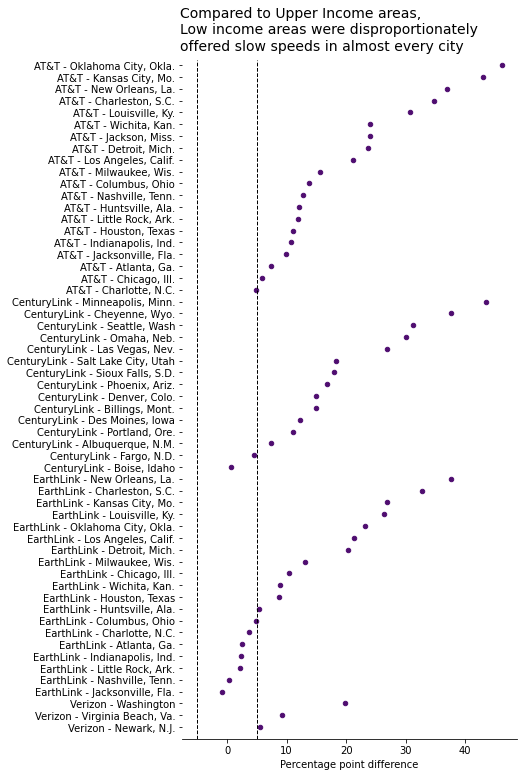

In [55]:
plot_observed(table, iv='income', fn=fn_observed_income,
              ylim=57,
              title = "Compared to Upper Income areas,\nLow income areas were disproportionately\noffered slow speeds in almost every city",)

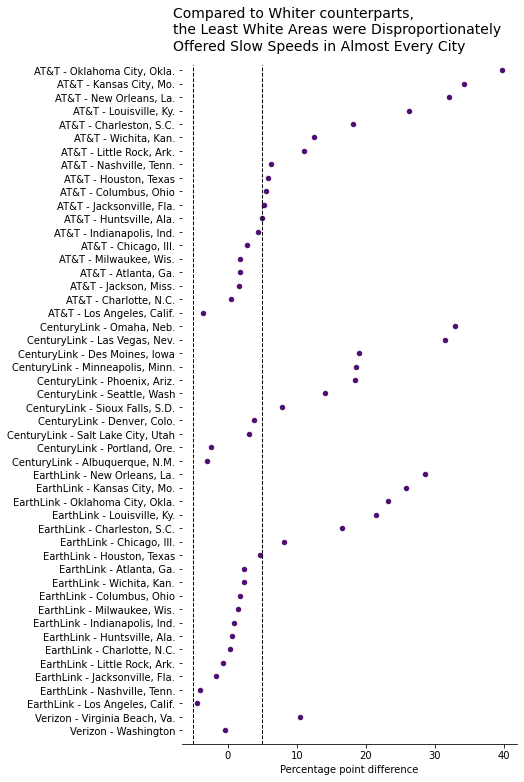

In [56]:
plot_observed(table, iv='race', fn=fn_observed_race, ylim=50,
              title = f"Compared to Whiter counterparts,\nthe Least White Areas were Disproportionately\nOffered Slow Speeds in Almost Every City")

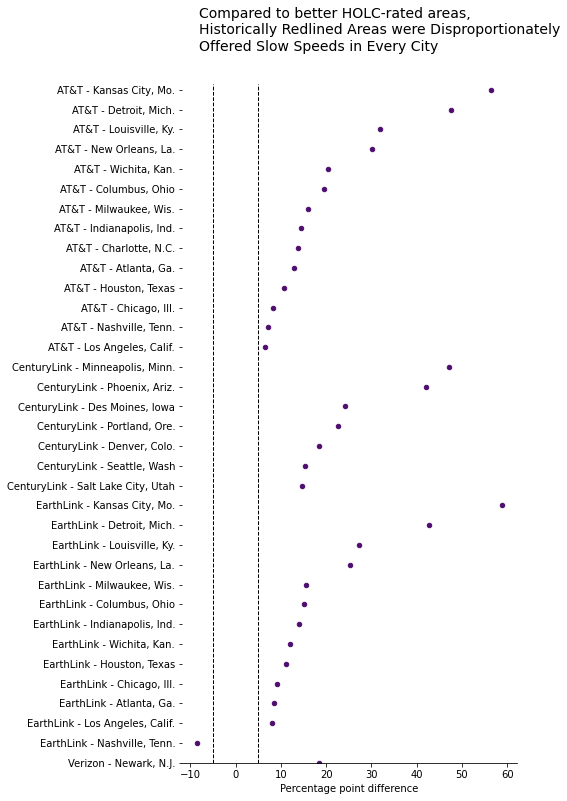

In [57]:
plot_observed(table, iv='redlining', fn=fn_observed_redlining, ylim=34,
              title = f"Compared to better HOLC-rated areas,\nHistorically Redlined Areas were Disproportionately\nOffered Slow Speeds in Every City",
)

## Regression

In [58]:
def preprocess_for_log_reg(df):
    df['n_providers'] = df['n_providers'] - 1
    df['income_dollars_below_median'] = df['income_dollars_below_median'] / 100

    df['constant'] = 1
    scaler = StandardScaler()
    df['lat_standard'] = scaler.fit_transform(df[['lat']])[:, 0]
    scaler = StandardScaler()
    df['lon_standard'] = scaler.fit_transform(df[['lon']])[:, 0]
    scaler = StandardScaler()
    df['ppl_per_sq_mile_standard'] = scaler.fit_transform(df[['ppl_per_sq_mile']])[:, 0]
    scaler = StandardScaler()
    df['income_dollars_below_median'] = scaler.fit_transform(df[['income_dollars_below_median']])[:, 0]
    
    # if there are no competitors, make this variable null.
    # Then this variable is linked to the outcome.
    df.loc[df.n_providers < 1, 'internet_perc_broadband'] = None
    
    scaler = StandardScaler()
    df['internet_perc_broadband'] = scaler.fit_transform(df[['internet_perc_broadband']])[:, 0]

    # this is our DV
    df['is_slow'] = df.apply(
        lambda x: 1 if x['speed_down_bins'] == "Slow (<25 Mbps)" else 0, 
        axis=1
    )
    
    for iv in ['income_level', 'race_quantile', 'redlining_grade']:
        df[iv] = df[iv].apply(lambda x: grade2rest.get(x, x))
    return df  

In [59]:
def train_and_return_coefs(formula, df, city, isp, model_name):
    """
    Workflow for fitting binary logistic regression for `formula`.
    This is formatted strangely because it'll be called by multiprocess(ing).Pool.
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    import pandas as pd
    import numpy as np
    try:
        results = smf.logit(formula=formula, data=df).fit(disp=0)
        coefs = pd.DataFrame({
            'coef': results.params.values,
            'odds_ratio': np.exp(results.params.values),
            'pvalue': results.pvalues,
            'pr_sq': results.prsquared,
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'intercept': results.params['Intercept'],
        })
    except Exception as e:
        coefs = pd.DataFrame([{
            'N' : len(df),
            'major_city': city,
            'state' : df.state.iloc[0],
            'isp': isp,
            'model' : model_name,
            'error': e
        }])
    
    return coefs

In [60]:
def odds_to_probability(row, step=1):
    """
    See about this equation here:
    http://faculty.cas.usf.edu/mbrannick/regression/Logistic.html
    """
    a = row['intercept']
    b = row['coef']
    X = step
    try:
        return math.exp(a + b * X) / (1 + math.exp(a + b * X))
    except:
        return None

In [61]:
iv2treatment = {
    "income_level" : 'Upper Income',
    "race_quantile" : 'most white',
    "redlining_grade" : 'rest'
}

grade2rest = {
    'A' : 'rest',
    'B' : 'rest',
}

In [62]:
if not os.path.exists(fn_regression_all) or recalculate:
    data_regression = pd.DataFrame([])
    
    args = []
    for isp, fn in inputs.items():
        df = filter_df(fn, isp)
        df['major_city'] = df['major_city'].apply(lambda x: x.title())
        for (city, state), _df in df.groupby(by=['major_city', 'state']):
            _df = bucket_and_bin(_df)
            _df = preprocess_for_log_reg(_df)
            
            n_slow = len(_df[_df.speed_down_bins == 'Slow (<25 Mbps)'])
            n_not_slow = len(_df[_df.speed_down_bins != 'Slow (<25 Mbps)'])
            n_all = len(_df)
            if (_df.speed_down_bins.nunique() <= 1) or (n_slow / n_all <= .01) or (n_not_slow / n_all <= .01):
                # not enough speed
                continue
            for iv, treatment in iv2treatment.items():
                if iv == 'race_quantile':
                    n_minority_white = len(_df[_df.race_perc_non_white > .5])    
                    n_majority_white = len(_df[_df.race_perc_non_white < .5])            

                    # check only cities with at least 5 percent of addresses in minority white.
                    if n_minority_white / len(_df) <= .05 or n_majority_white / len(_df) <= .05:
                        print(f"skip {city} {isp} race")
                        continue
                elif iv == 'redlining_grade':
                    _df_rated = _df[~_df.redlining_grade.isnull()]
                    if len(_df_rated) <= len(_df) * .05:
                        print(f"skip {city} {isp} redline")
                        continue
                    if 'D' not in _df['redlining_grade'].unique().tolist():
                        print(f"skip {city} {isp} redline")
                        continue

                formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                args.append([formula, _df, city, isp, f"{iv}_alone"])
                if city in ['Omaha', 'Phoenix'] and iv == 'redlining_grade':
                    formula += " + ppl_per_sq_mile_standard + internet_perc_broadband"
                else:
                    formula += " + ppl_per_sq_mile_standard + n_providers + internet_perc_broadband"
                args.append([formula, _df, city, isp, f"{iv}_controls"])

                # ablation formulas
                if city in ['Omaha', 'Phoenix'] and iv == 'redlining_grade':
                    formulas = [" + ppl_per_sq_mile_standard", " + internet_perc_broadband"]
                else:
                    formulas = [" + ppl_per_sq_mile_standard", " + n_providers ",  " + internet_perc_broadband"]
                for iv_ in formulas:
                    formula = f"is_slow ~ C({iv}, Treatment('{treatment}'))"
                    formula += "".join([f for f in formulas if f != iv_])
                    model_name =  f"{iv}_minus{iv_.replace(' + ', '_')}"
                    args.append([formula, _df, city, isp, model_name])

    with multiprocess.get_context("spawn").Pool(n_jobs) as pool:
        for coefs in tqdm(pool.istarmap(train_and_return_coefs, args), 
                           total=len(args)):
            data_regression = data_regression.append(coefs)

    # treatment group IE upper income, most white, best graded
    data_regression['probability_treatment'] = data_regression.apply(odds_to_probability, step=0, axis=1)
    # exposure group IE lower income, least white, redlined
    data_regression['probability_exposure'] = data_regression.apply(odds_to_probability, step=1, axis=1)
    data_regression['odds_directional'] = data_regression.apply(lambda x: x['odds_ratio'] * -1 if x['coef'] <0 else  x['odds_ratio'], axis=1)
    data_regression['is_coef_positive'] = data_regression.coef > 0
    # positive if exposure group has higher liklihood of slower speeds than treatment group
    data_regression['probability_delta'] = data_regression['probability_exposure'] - data_regression['probability_treatment']
    data_regression['perc_probability'] =  data_regression['probability_exposure'] / data_regression['probability_treatment']
    data_regression = data_regression[data_regression.index != 'Intercept']

    data_regression.to_csv(fn_regression_all)
    controls = data_regression[data_regression.model.str.contains('_controls')]
    controls.loc["C(income_level, Treatment('Upper Income'))[T.Low]"].to_csv(fn_regression_income)
    controls.loc["C(race_quantile, Treatment('most white'))[T.least white]"].to_csv(fn_regression_race)
    controls.loc["C(redlining_grade, Treatment('rest'))[T.D]"].to_csv(fn_regression_redlining)
    
else:
    data_regression = pd.read_csv(fn_regression_all, index_col=0)

skip Charleston AT&T redline
skip Detroit AT&T race
skip Huntsville AT&T redline
skip Jacksonville AT&T redline
skip Oklahoma City AT&T redline
skip Albuquerque CenturyLink redline
skip Billings CenturyLink race
skip Billings CenturyLink redline
skip Boise CenturyLink race
skip Boise CenturyLink redline
skip Cheyenne CenturyLink race
skip Cheyenne CenturyLink redline
skip Fargo CenturyLink race
skip Fargo CenturyLink redline
skip Las Vegas CenturyLink redline
skip Sioux Falls CenturyLink redline


/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nyc)


skip Newark Verizon race
skip Virginia Beach Verizon redline
skip Washington Verizon redline
skip Charleston EarthLink redline
skip Detroit EarthLink race
skip Huntsville EarthLink redline
skip Jacksonville EarthLink redline
skip Las Vegas EarthLink redline
skip Oklahoma City EarthLink redline


  0%|          | 0/773 [00:00<?, ?it/s]<ipython-input-62-2d32d505f14c>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_regression = data_regression.append(coefs)
  0%|          | 1/773 [00:01<18:00,  1.40s/it]<ipython-input-62-2d32d505f14c>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_regression = data_regression.append(coefs)
<ipython-input-62-2d32d505f14c>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_regression = data_regression.append(coefs)
<ipython-input-62-2d32d505f14c>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_regression = data_regression.append(coefs)
<ipython-input-62-2d32d505f14c>:58: Fu

## Ablation

In [64]:
# mean psuedo r-squared (goodness of fit) for each model across cities and ISPs.
for model, _df in data_regression.groupby(['model']):
    mean_pr = _df.groupby(['major_city', 'state', 'isp']).first().pr_sq.mean()
    print(model, mean_pr)

income_level_alone 0.0391152037021271
income_level_controls 0.0796425133739523
income_level_minus_internet_perc_broadband 0.07390415710589603
income_level_minus_n_providers  0.06788779468009006
income_level_minus_ppl_per_sq_mile_standard 0.06229908347156088
race_quantile_alone 0.023202525598921483
race_quantile_controls 0.07791385413083791
race_quantile_minus_internet_perc_broadband 0.06344374266945502
race_quantile_minus_n_providers  0.06646836652990351
race_quantile_minus_ppl_per_sq_mile_standard 0.05788842788939328
redlining_grade_alone 0.053904110555880465
redlining_grade_controls 0.12182658400070799
redlining_grade_minus_internet_perc_broadband 0.10988232850184365
redlining_grade_minus_n_providers  0.0986995836812461
redlining_grade_minus_ppl_per_sq_mile_standard 0.09411610569618546


<ipython-input-64-82dc4a74ca6a>:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for model, _df in data_regression.groupby(['model']):


The ablated IV that results in the least change from the observed are the most influential.

In [65]:
income_ablation = data_regression[
    (data_regression['model'].str.contains('income_level_minus_')) &
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]") &
    (data_regression.major_city.isin(income_cities))
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation['delta'] = abs(income_ablation['probability_delta'] - income_ablation['income_pct_pt_diff'])
income_ablation.sort_values(by='delta', ascending=True).groupby(['major_city', 'isp']).first().model.value_counts(normalize=True)

income_level_minus_internet_perc_broadband     0.482759
income_level_minus_n_providers                 0.344828
income_level_minus_ppl_per_sq_mile_standard    0.172414
Name: model, dtype: float64

In [66]:
race_ablation = data_regression[
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]") &
    (data_regression.major_city.isin(race_cities))
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation['delta'] = abs(race_ablation['probability_delta'] - race_ablation['race_pct_pt_diff'])
race_ablation.sort_values(by='delta', ascending=True).groupby(['major_city', 'isp']).first().model.value_counts(normalize=True)

race_quantile_minus_internet_perc_broadband     0.450980
race_quantile_minus_n_providers                 0.333333
race_quantile_minus_ppl_per_sq_mile_standard    0.215686
Name: model, dtype: float64

In [67]:
redlining_ablation = data_regression[
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]") &
    (data_regression.major_city.isin(redlining_cities))
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation['delta'] = abs(redlining_ablation['probability_delta'] - redlining_ablation['redlining_pct_pt_diff'])
redlining_ablation.sort_values(by='delta', 
                               ascending=False).groupby(['major_city', 'isp']).first().model.value_counts(normalize=True)

redlining_grade_minus_ppl_per_sq_mile_standard    0.583333
redlining_grade_minus_internet_perc_broadband     0.277778
redlining_grade_minus_n_providers                 0.138889
Name: model, dtype: float64

## Where to disparities persist?

In [68]:
income = (
    data_regression[
        (data_regression.model == f'income_level_controls') &
        (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'income_level_alone') &
            (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
income = income[income.major_city.isin(income_cities)]

race = (
    data_regression[
        (data_regression.model == f'race_quantile_controls') &
        (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
    ].sort_values(['coef', 'state'], ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'race_quantile_alone') &
            (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
race = race[race.major_city.isin(race_cities)]

redlining = (
    data_regression[
        (data_regression.model == f'redlining_grade_controls') &
        (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
    ].sort_values('coef', ascending=False)
    .merge(
        data_regression[
            (data_regression.model == f'redlining_grade_alone') &
            (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
        ], how='left', on=['major_city', 'state', 'isp'],
        suffixes=['', '_alone']
    )
).drop_duplicates(subset=['isp', 'major_city', 'state'])
redlining = redlining[redlining.major_city.isin(redlining_cities)]

In [69]:
city_isp_income = income[~income.pvalue.isnull()]
slowest_income = city_isp_income[city_isp_income.probability_delta > 0.05]

city_isp_race = race[~race.pvalue.isnull()]
slowest_race = city_isp_race[city_isp_race.probability_delta > 0.05]

city_isp_redlining = redlining[~redlining.pvalue.isnull()]
slowest_redlining = city_isp_redlining[city_isp_redlining.probability_delta > 0.05]

print(f"Income ({len(city_isp_income)} city-ISP pairs and {city_isp_income.major_city.nunique()} cities) even after adjusting for other factors..."
     f"\n- lower income areas recieve greater proprotion of slow speeds in {len(slowest_income)} city-ISP pairs, or {len(slowest_income) / len(city_isp_income) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_income.major_city.nunique()} out of {city_isp_income.major_city.nunique()} cities ({slowest_income.major_city.nunique() / city_isp_income.major_city.nunique():.2f}%)")
print(f"Race and Ethnicity ({len(city_isp_race)} city-ISP pairs) even after adjusting for other factors..."
     f"\n- least white areas recieve greater proportion of slow speeds in {len(slowest_race)} city-ISP pairs, or {len(slowest_race) / len(city_isp_race) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_race.major_city.nunique()} out of {city_isp_race.major_city.nunique()} cities ({slowest_race.major_city.nunique() / city_isp_race.major_city.nunique():.2f}%)")

print(f"Redlining ({len(city_isp_redlining)} city-ISP pairs) even after adjusting for other factors..."
     f"\n- hazardous areas recieve greater proprotion of slow speeds in {len(slowest_redlining)} city-ISP pairs, or {len(slowest_redlining) / len(city_isp_redlining) * 100:.1f}% of cases.\n"
     f"- same pattern in {slowest_redlining.major_city.nunique()} out of {city_isp_redlining.major_city.nunique()} cities ({slowest_redlining.major_city.nunique() / city_isp_redlining.major_city.nunique():.2f}%)")


Income (58 city-ISP pairs and 38 cities) even after adjusting for other factors...
- lower income areas recieve greater proprotion of slow speeds in 40 city-ISP pairs, or 69.0% of cases.
- same pattern in 26 out of 38 cities (0.68%)
Race and Ethnicity (51 city-ISP pairs) even after adjusting for other factors...
- least white areas recieve greater proportion of slow speeds in 14 city-ISP pairs, or 27.5% of cases.
- same pattern in 10 out of 32 cities (0.31%)
Redlining (36 city-ISP pairs) even after adjusting for other factors...
- hazardous areas recieve greater proprotion of slow speeds in 20 city-ISP pairs, or 55.6% of cases.
- same pattern in 13 out of 22 cities (0.59%)


In [70]:
# what percentage of AT&T cities do income disparities persist?
income_att = income[income.isp == 'AT&T']
len(income_att[income_att.probability_delta >= .05]) / len(income_att)

0.75

Misc model outputs for methodology

In [71]:
len(income[income.pvalue < .05]) / len(income)

0.896551724137931

In [72]:
income.pr_sq.describe()

count    58.000000
mean      0.076554
std       0.055670
min       0.004665
25%       0.040706
50%       0.059516
75%       0.096564
max       0.245979
Name: pr_sq, dtype: float64

In [73]:
income.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

True     0.827586
False    0.172414
Name: odds_ratio, dtype: float64

In [74]:
len(race[race.pvalue < .05]) / len(race)

0.7843137254901961

In [75]:
race.pr_sq.describe()

count    51.000000
mean      0.074289
std       0.052823
min       0.006325
25%       0.037003
50%       0.066467
75%       0.087849
max       0.244720
Name: pr_sq, dtype: float64

In [76]:
race.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

False    0.54902
True     0.45098
Name: odds_ratio, dtype: float64

In [77]:
len(redlining[redlining.pvalue < .05]) / len(redlining)

0.9166666666666666

In [78]:
redlining.pr_sq.describe()

count    36.000000
mean      0.116523
std       0.070254
min       0.032422
25%       0.054747
50%       0.110309
75%       0.151552
max       0.321479
Name: pr_sq, dtype: float64

In [79]:
redlining.odds_ratio.apply(lambda x: x>1.5).value_counts(normalize=True)

True     0.833333
False    0.166667
Name: odds_ratio, dtype: float64

### See the factor that lead to the greatest adjustments for any city

In [80]:
income_ablation_ = data_regression[
    (data_regression['major_city'] == 'Seattle') &
    (data_regression['model'].str.contains('income_level_minus_')) & 
    (data_regression.index == "C(income_level, Treatment('Upper Income'))[T.Low]")
].merge(table, on=['isp', 'major_city', 'state'])
income_ablation_['delta'] = abs(income_ablation_['probability_delta'] - 
                                income_ablation_['income_pct_pt_diff'])
income_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,race_pct_pt_diff,flag_race,redlining_disparity,pct_slow_d_rated,pct_slow_ab_rated,redlining_pct_pt_diff,flag_redlining,x_red,Observed,delta
1,0.861468,2.366632,2.990880e-42,0.201086,17938,Seattle,WA,CenturyLink,income_level_minus_n_providers,-1.172061,...,0.1415,None,True,0.315,0.1619,0.1531,None,1.945645,0.1531,0.125913
0,1.211941,3.359999,4.651078e-94,0.132542,17938,Seattle,WA,CenturyLink,income_level_minus_ppl_per_sq_mile_standard,-3.189751,...,0.1415,None,True,0.315,0.1619,0.1531,None,1.945645,0.1531,0.230401
2,0.623199,1.864885,1.592815e-28,0.227498,17938,Seattle,WA,CenturyLink,income_level_minus_internet_perc_broadband,-2.486467,...,0.1415,None,True,0.315,0.1619,0.1531,None,1.945645,0.1531,0.254890


In [81]:
race_ablation_ = data_regression[
    (data_regression['major_city'] == 'Charleston') &
    (data_regression['model'].str.contains('race_quantile_minus_')) &
    (data_regression.index == "C(race_quantile, Treatment('most white'))[T.least white]")
].merge(table, on=['isp', 'major_city', 'state'])
race_ablation_['delta'] = abs(race_ablation_['probability_delta'] - 
                              race_ablation_['race_pct_pt_diff'])
race_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,race_pct_pt_diff,flag_race,redlining_disparity,pct_slow_d_rated,pct_slow_ab_rated,redlining_pct_pt_diff,flag_redlining,x_red,Observed,delta
3,0.435401,1.545583,0.002118,0.055891,3132,Charleston,SC,EarthLink,race_quantile_minus_ppl_per_sq_mile_standard,1.245929,...,0.1659,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.099414
5,0.230481,1.259206,0.051822,0.093257,3132,Charleston,SC,EarthLink,race_quantile_minus_internet_perc_broadband,-0.384099,...,0.1659,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.109368
2,0.196539,1.217183,0.110563,0.211376,3849,Charleston,SC,AT&T,race_quantile_minus_internet_perc_broadband,0.817976,...,0.1813,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.141204
4,0.035899,1.036551,0.808482,0.093346,3132,Charleston,SC,EarthLink,race_quantile_minus_n_providers,-0.819966,...,0.1659,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.158227
0,0.195054,1.215376,0.214174,0.169643,3849,Charleston,SC,AT&T,race_quantile_minus_ppl_per_sq_mile_standard,2.755458,...,0.1813,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.171233
1,-0.471807,0.623874,0.004227,0.202148,3849,Charleston,SC,AT&T,race_quantile_minus_n_providers,-1.124801,...,0.1813,None,NaN,NaN,NaN,NaN,not HOLC graded,NaN,NaN,0.257966


In [82]:
redlining_ablation_ = data_regression[
    (data_regression['major_city'] == 'Minneapolis') &
    (data_regression['model'].str.contains('redlining_grade_minus_')) &
    (data_regression.index == "C(redlining_grade, Treatment('rest'))[T.D]")
].merge(table, on=['isp', 'major_city', 'state'])
redlining_ablation_['delta'] = abs(redlining_ablation_['probability_delta'] - 
                                  redlining_ablation_['redlining_pct_pt_diff'])
redlining_ablation_.sort_values(by='delta', ascending=True)

,coef,odds_ratio,pvalue,pr_sq,N,major_city,state,isp,model,intercept,...,race_pct_pt_diff,flag_race,redlining_disparity,pct_slow_d_rated,pct_slow_ab_rated,redlining_pct_pt_diff,flag_redlining,x_red,Observed,delta
2,3.157450,23.510578,3.203916e-240,0.286395,11583,Minneapolis,MN,CenturyLink,redlining_grade_minus_internet_perc_broadband,-3.424075,...,0.1858,None,True,0.5335,0.0622,0.4713,None,8.57717,0.4713,0.069115
1,2.362000,10.612153,5.189899e-136,0.312362,11583,Minneapolis,MN,CenturyLink,redlining_grade_minus_n_providers,-2.618429,...,0.1858,None,True,0.5335,0.0622,0.4713,None,8.57717,0.4713,0.103020
0,2.218028,9.189189,7.083669e-124,0.254240,11583,Minneapolis,MN,CenturyLink,redlining_grade_minus_ppl_per_sq_mile_standard,-3.666213,...,0.1858,None,True,0.5335,0.0622,0.4713,None,8.57717,0.4713,0.305955


## Plots with Adjustments

In [83]:
label2marker = {
    'Observed': 'o',
    'Adjusted': '^'
}

In [84]:
def plot_adjusted(to_plot, ylim=33.5, figsize=(6, 8), fn=fn_adjusted_redlining,
                  title= f"After adjusting for other factors, Redlined areas\nstill disprportionately offered slow Internet speeds",
                  title_y = -3.2, title_x= -.05):
    legend_elements = [Line2D([0], [0], marker=label2marker.get(label), color='w', 
                          label=label, markerfacecolor=c, markersize=10)
                   for label, c in {'Observed': color_1, 'Adjusted': color_2}.items()][::-1] 
    
    to_plot_ = to_plot#[(to_plot['pvalue'] < 0.05)]
    to_plot_['major_city_isp'] = to_plot_.apply(lambda x: x['isp'] + ' - ' + x['major_city'], axis=1)

    to_plot_['Observed'] = to_plot_.probability_delta_alone * 100
    to_plot_['Adjusted'] = to_plot_.probability_delta * 100

    to_plot_ = to_plot_.sort_values(by=['Adjusted', 'state', 'Observed'], ascending=False)

    ax = to_plot_.plot(y='major_city_isp', x='Observed', 
                      color=color_1,
                      kind='scatter', figsize=figsize)
    to_plot_.plot(y='major_city_isp', x='Adjusted', 
                 color=color_2, ax=ax, marker='^',
                 alpha = [bool2alpha.get(_) for _ in to_plot_.pvalue < 0.05],
                 kind='scatter')

    x1 = to_plot_['Adjusted'].tolist()
    x2 = to_plot_['Observed'].tolist()
    n = to_plot_['major_city_isp'].tolist()
    for i in range(0, len(x1)):
        ax.plot([x1[i], x2[i]], [n[i], n[i]], '-', 
                color='black', zorder=-1, alpha=.8)

    to_plot_['isp'] = pd.Categorical(to_plot_['isp'], ["AT&T", "Verizon", "CenturyLink", "EarthLink"])
    to_plot_ = to_plot_.sort_values(by=['isp','Adjusted', 'state', 'Observed'], 
                                    ascending=[True, False, False, False])
    to_plot_[['major_city', 'isp', 'Adjusted', 'Observed', 'state']].to_csv(fn, index=False)    

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    plt.gca().invert_yaxis()

    ax.set_ylabel("")
    ax.set_xlabel("Percentage point difference")

    plt.axvline(x=0,linewidth=1, color='black', linestyle='--', ymax=.96)

    plt.text(title_x, title_y, 
             title,
             size=14,
             horizontalalignment='left',
             verticalalignment='center',);
    ax.set_ylim(bottom=ylim)

    ax.legend(handles=legend_elements[::-1],
                  loc='lower left', 
                  bbox_to_anchor= (-0.025, .97), 
                  ncol=5,
                  handletextpad=0.0,
                  labelspacing=0, 
                  borderaxespad=.1, 
                  borderpad=0.1,
                  frameon=False,
                  prop={'size': 9.2})

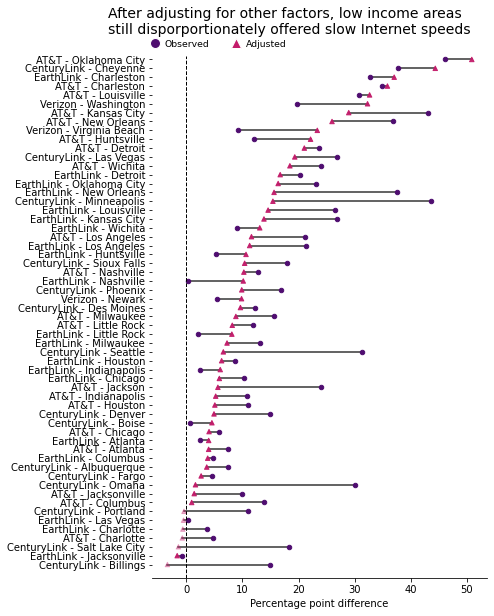

In [85]:
to_plot = income
plot_adjusted(to_plot, ylim=58.5, figsize=(6, 10), 
              fn=fn_adjusted_income,
              title_y = -4.2, title_x = -14, 
              title= f"After adjusting for other factors, low income areas\nstill disporportionately offered slow Internet speeds",
)

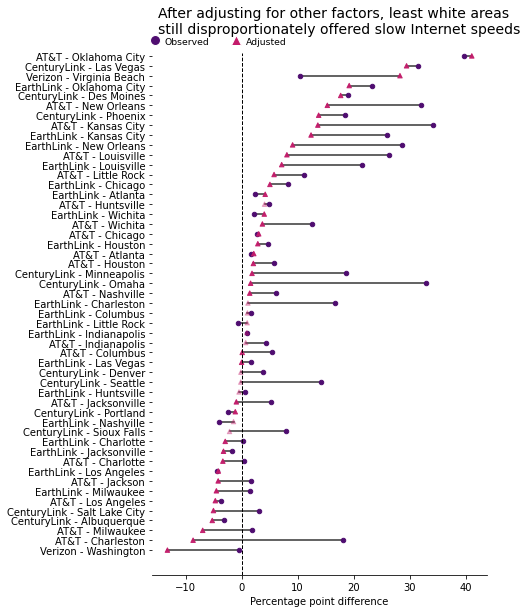

In [86]:
to_plot = race
plot_adjusted(to_plot, ylim=52.5, figsize=(6, 10), 
              fn=fn_adjusted_race,
              title_y = -3.5, title_x = -15,
              title= f"After adjusting for other factors, least white areas\nstill disproportionately offered slow Internet speeds",
)

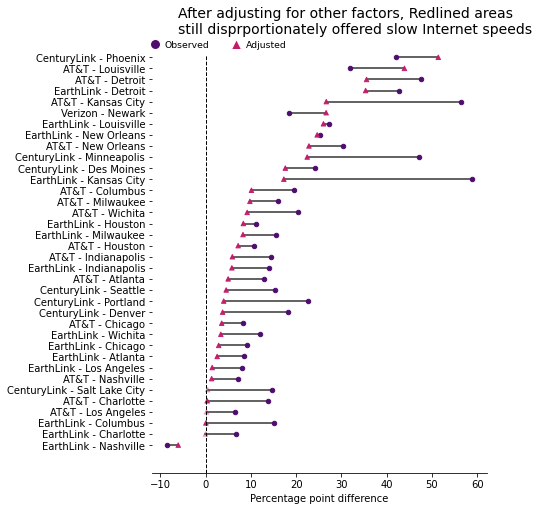

In [87]:
to_plot = redlining
plot_adjusted(to_plot, title_y=-3.2, title_x=-6, ylim=37.5, fn=fn_adjusted_redlining)

### Rates per plan

In [88]:
fn_rates = '../data/output/figs/story_rates.csv'

In [89]:
isp_rates = []
for isp, fn in inputs.items():
    df_ = filter_df(fn, isp)
    # remove no service and affordable plans
    df_ = df_[(df_.speed_down != 0) & (df_.price > 30)]
    df_['std_rate'] = df_['price'] / df_['speed_down']
    rate_lowest = df_['std_rate'].min()
    rate_highest = df_['std_rate'].max()
    
    isp_rates.append({
        'isp' : isp,
        'rate_lowest': rate_lowest,
        'rate_highest': rate_highest,
        'price' : df_['price'].iloc[0]
    })

/home/chino/code/1_production-grade/isp/notebooks/aggregators.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(nyc)


In [90]:
isp_rates

[{'isp': 'AT&T',
  'rate_lowest': 0.13,
  'rate_highest': 71.61458333333333,
  'price': 55.0},
 {'isp': 'CenturyLink',
  'rate_lowest': 0.25,
  'rate_highest': 100.0,
  'price': 50.0},
 {'isp': 'Verizon',
  'rate_lowest': 0.1333,
  'rate_highest': 5.632394366197183,
  'price': 39.99},
 {'isp': 'EarthLink',
  'rate_lowest': 0.5995,
  'rate_highest': 19.983333333333334,
  'price': 59.95}]

In [91]:
pd.DataFrame(isp_rates).to_csv(fn_rates, index=False)